# Mean Square End-to-End Fluctuations

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from os import listdir
import pandas as pd
import statsmodels.formula.api as sm

In [2]:
def CreateLpDataFrame(dirName):
    assert isinstance(dirName, str), "The 'dirName' argument must be a string!"
    fileNames = [dirName+'/'+i for i in listdir(dirName) if i[-6:] == '.mse2e']
    #df = pd.DataFrame(columns=['length','diameter','child_length','persistence_length','driving','ndim','nsteps','nspec','delta','theory'])
    df = pd.DataFrame(columns=['n_filaments','length','child_length','persistence_length','driving','ndim','theory','mse2e','std_err'])
    for filename in fileNames:
        f=open(filename)
        f.readline()
        f.readline()
        line = list(map(float,f.readline().split()))
        length,childLength,perlen,driving,ndim,theory = line[0],line[2],line[3],line[4],line[5],line[9]
        f.readline()
        line = f.readline().split()
        num,mse2e,stderr = int(line[0]),float(line[1]),float(line[2])
        f.close()
        temp_df = pd.DataFrame(data={'n_filaments':num,'length':length,'child_length':childLength,'persistence_length':perlen,'driving':driving,'ndim':ndim,'theory':theory,'mse2e':mse2e,'std_err':stderr},index=[1])
        df = df.append(temp_df,ignore_index=True)
    return df

def GetRealUnits(df):
    df.loc[:,'length (nm)'] = df['length'].apply(lambda y: y*25.0)
    df.loc[:,'driving (pN/nm)'] = df['driving'].apply(lambda y: y*0.0064)
    df.loc[:,'persistence_length (nm)'] = df['persistence_length'].apply(lambda y: y*25.0)
    df.loc[:,'child_length (nm)'] = df['child_length'].apply(lambda y: y*25.0)
    df.loc[:,'mse2e (nm^2)'] = df['mse2e'].apply(lambda y: y*25.0)
    df.loc[:,'std_err (nm^2)'] = df['std_err'].apply(lambda y: y*25.0)
    df.loc[:,'theory (nm^2)'] = df['theory'].apply(lambda y: y*25.0)
    df.loc[:,'effective_lp (nm)'] = df['effective_lp'].apply(lambda y: y*25.0)
    df.loc[:,'eff_lp_std_err (nm)'] = df['eff_lp_std_err'].apply(lambda y: y*25.0)


def BackCalc(row):
    lps = np.linspace(10,1000000,1000000)
    mse2e_func = lambda L,Lp,ndim: (2 if ndim==3 else 4)*L*Lp - (2 if ndim==3 else 8)*Lp*Lp*(1-np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp))
    ind=(abs(row['mse2e']-mse2e_func(row['length'],lps,row['ndim']))).argmin()
    return round(lps[ind])

def BackCalcErr(row):
    mse2e_deriv_func = lambda L,Lp,ndim: (2 if ndim==3 else 4)*L + (2 if ndim==3 else 4)*L*np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp) - 2*Lp*(2 if ndim==3 else 8)*(1-np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp))
    return row['std_err']/mse2e_deriv_func(row['length'],row['effective_lp'],row['ndim'])
    #return abs(lps[ind+1]-lps[ind-1])/abs(mse2e_func(row['length'],lps[ind+1],row['ndim'])-mse2e_func(row['length'],lps[ind-1],row['ndim']))

def BackCalculateLp(df,range_min=50,range_max=50000):
    df.loc[:,'effective_lp'] = df.apply(BackCalc, axis=1)
    df.loc[:,'eff_lp_std_err'] = df.apply(BackCalcErr, axis=1)
    
def CreateMasterThetaDF(dirName="."):
    """CreateMasterThetaDF(dirName) where dirName is the directory name of the .theta files,
       output pandas dataframe of all theta files header data and filenames"""
    assert isinstance(dirName, str), "The 'dirName' argument must be a string!"
    fileNames = [dirName+'/'+i for i in listdir(dirName) if i[-6:] == '.theta']
    
    if len(fileNames)==0:
        print("No '.theta' files found in directory '"+dirName+"'.")
        return
    
    D = {"file_name" : []}
    for index,name in enumerate(fileNames):
        f = open(name,'r')
        for i in range(2): colNames = f.readline().split()
        if index == 0:
            for colName in colNames:
                D[colName] = []
        D["file_name"].append(name)
        simParams = f.readline().split()
        for colIndex,colName in enumerate(colNames):
            D[colName].append(float(simParams[colIndex]))
        f.close()
    df = pd.DataFrame(D)
    return df

def CreateThetaDF(fileName):
    """CreateThetaDF(fileName) where fileName is the name of the .theta file,
       output pandas dataframe of .theta histogram data"""
    assert isinstance(fileName, str), "The 'fileName' argument must be a string!"
    try:
        f = open(fileName,'r')
    except:
        print("Failed to open file '" + fileName + "'.")
        return
    
    for i in range(4): colNames = f.readline().split()
    D = {}
    for colName in colNames:
        D[colName] = []
    for line in f:
        line = line.split()
        for colIndex, colName in enumerate(colNames):
            D[colName].append(float(line[colIndex]))
    f.close()
    df = pd.DataFrame(D)
    return df

def CreatePlotsMaster(master_df):
    """TODO"""
    assert isinstance(master_df,pd.DataFrame),"master_df must be pandas DataFrame type"
    
    for i in master_df.index:
        CreateThetaPlot(master_df.iloc[i])
    
def CreateThetaPlot(theta_series,laFactor=1):
    """CreateThetaPlot(dataframe) where dataframe is a pandas Series that
    contains the header data for a .theta file (a slice of a theta master dataframe)"""
    
    assert isinstance(theta_series,pd.Series),"theta_series must be pandas Series type"
    if theta_series["n_dim"]!=3:
        return
    df=CreateThetaDF(theta_series["file_name"])
    factor = 0.5*len(df.index)*theta_series["n_spec"]/theta_series["n_filaments"]/theta_series["n_steps"]*100
    for k in range(1,len(df.columns)):
        s = df.iloc[:,k]
        err = pd.Series(np.zeros(len(df.index)))
        for i,j in enumerate(s):
            err[i] = np.sqrt(j)*factor
        s *= factor
        df[df.columns[k]+'_err']=err

    plotEvery=10
    plt.figure()
    plt.errorbar(df.iloc[:,0][::plotEvery],df.iloc[:,1][::plotEvery],yerr=df['theta_12_err'][::plotEvery])
    la = theta_series["persistence_length"]/theta_series["child_length"]
    if la == 0:
        const = 2.0
    else:
        la=laFactor*la
        const = 2.0*np.sinh(la)/(la)
    y = lambda x : np.exp(la*x)/const
    x=np.linspace(-1.0,1.0,10000)
    plt.plot(x,y(x),'r-')
    if theta_series["persistence_length"] == 0:
        plt.ylim(0,1)
    plt.title('Lp = '+str(theta_series["persistence_length"])+", L = "+str(theta_series["length"])+", cL = "+str(theta_series["child_length"]))
    plt.xlabel(r'cos($\theta$)')
    plt.ylabel(r'P(cos($\theta$))')
    plt.legend(["Simulation","Theory"],loc=2)
    lp = theta_series["persistence_length"]
    if (lp > 10):
        plt.xlim(0,1)
        if (lp > 100):
            plt.xlim(0.9,1)
            if (lp > 300):
                plt.xlim(0.95,1)
                
    plt.show()
    #plt.close()

### Next cell is raw text, convert back to code to rerun

In [3]:
df = CreateLpDataFrame('mse2e_long_slender_dr_20_delta_0.0001/')
BackCalculateLp(df)
GetRealUnits(df)
df.to_pickle('mse2e_long_slender_dr_20_delta_0.0001.pkl')
#df = CreateMasterThetaDF('mse2e_thetas')
#df.to_pickle('mse2e_long_slender.pkl')

In [4]:
df = CreateLpDataFrame('mse2e_long_slender_dr_00_delta_0.0001_reduced10/')
BackCalculateLp(df)
GetRealUnits(df)
df.to_pickle('mse2e_long_slender_dr_00_delta_0.0001_reduced10.pkl')
#df = CreateMasterThetaDF('mse2e_thetas')
#df.to_pickle('mse2e_long_slender.pkl')

In [16]:
df = CreateLpDataFrame('mse2e_long_slender_dr_20_delta_0.0001_tangent/')
BackCalculateLp(df)
GetRealUnits(df)
df.to_pickle('mse2e_long_slender_dr_20_delta_0.0001_tangent.pkl')
#df = CreateMasterThetaDF('mse2e_thetas')
#df.to_pickle('mse2e_long_slender.pkl')

In [36]:
df = pd.read_pickle('mse2e_long_slender_dr_20_delta_0.0001_tangent.pkl')
#df = pd.read_pickle('mse2e_long_slender_dr_20_delta_0.0001.pkl')
#thetaDF = pd.read_pickle('mse2e_thetas.pkl')
df["n_bonds"]=df["length"]/df["child_length"]

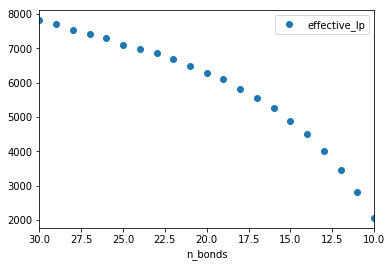

In [37]:
#thetaDF.head()
df.plot(x="n_bonds",y="effective_lp",style='o')
#df = pd.DataFrame({"A": [10,20,30,40,50], "B": [20, 30, 10, 40, 50], "C": [32, 234, 23, 23, 42523]})


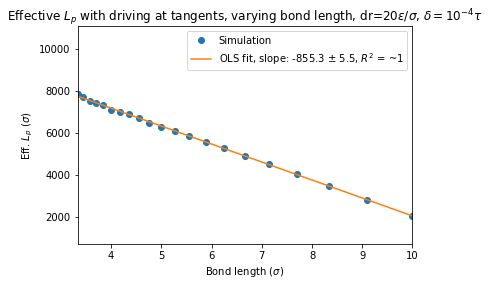

In [41]:
df.plot(x="child_length",y="effective_lp",style='o')
result = sm.ols(formula="effective_lp ~ child_length",data=df).fit()
b,m = result.params
y = lambda x: m*x+b
x = np.linspace(0,11,10)
plt.plot(x,y(x))
plt.title(r"Effective $L_p$ with driving at tangents, varying bond length, dr=20$\epsilon/\sigma$, $\delta=10^{-4}\tau$")
plt.ylabel("Eff. $L_p$ ($\sigma$)")
plt.xlabel("Bond length ($\sigma$)")
plt.legend(["Simulation","OLS fit, slope: %2.1f $\pm$ 5.5, $R^2$ = ~1"%m])

In [39]:
result.summary()#df3d = df[df['ndim']==3]
#df2d500 = df2d[df2d['persistence_length']==500.0]
#df3d500 = df3d[df3d['persistence_length']==500.0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           effective_lp   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.193e+04
Date:                Fri, 12 Jan 2018   Prob (F-statistic):           4.04e-34
Time:                        12:57:25   Log-Likelihood:                -102.05
No. Observations:                  21   AIC:                             208.1
Df Residuals:                      19   BIC:                             210.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.059e+04     22.035    480.652      0.000    1.05e+04    1.06e+04
child_length  -855.3317      3.753   -227.890      0.000    -863.187    -847.476
==============================================================================
Omnibus:                        6.401   Durbin-Watson:                   0.761
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                4.133
Skew:                           0.760   Prob(JB):                        0.127
Kurtosis:                       4.554   Cond. No.                         18.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
grouped=df2d500.groupby('child_length (nm)')
fig,ax=plt.subplots(nrows=1,ncols=len(grouped),figsize=(12,6),dpi=80)
i=0
for perlen,group in grouped:
    ax[i].set_title("MSE2E with driving, 3D\n" + r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.02)
    ax[i].errorbar(group['driving (pN/nm)'],group['mse2e (nm^2)'],yerr=group['std_err (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['theory (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['mse2e (nm^2)'])
    ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    ax[i].set_ylabel(r'MSE2E Distance (nm$^2$)',fontsize=14)
    ax[i].set_xlabel("Driving (pN/nm)",fontsize=14)
    ax[i].legend([r'Theory$_{dr=0}$','Sim','Std. Err.'],loc=3)
    ax[i].set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    i+=1
fig.tight_layout()#rect=(0.05,0.1,0.95,0.9),pad=0)
plt.show()

NameError: name 'df2d500' is not defined

In [ ]:
grouped=df2d500.groupby('child_length (nm)')
fig,ax=plt.subplots(nrows=1,ncols=len(grouped),figsize=(12,6),dpi=80)
i=0
for perlen,group in grouped:
    ax[i].set_title("MSE2E with driving, 3D\n" + r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.02)
    ax[i].errorbar(group['driving (pN/nm)'],group['mse2e (nm^2)'],yerr=group['std_err (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['theory (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['mse2e (nm^2)'])
    ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    ax[i].set_ylabel(r'MSE2E Distance (nm$^2$)',fontsize=14)
    ax[i].set_xlabel("Driving (pN/nm)",fontsize=14)
    ax[i].legend([r'Theory$_{dr=0}$','Sim','Std. Err.'],loc=3)
    ax[i].set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    i+=1
fig.tight_layout()#rect=(0.05,0.1,0.95,0.9),pad=0)
plt.show()

In [ ]:
df2d = df[df['ndim']==2]
#df3d = df[df['ndim']==3]
grouped=df2d.groupby('persistence_length (nm)')
fig,ax=plt.subplots(nrows=1,ncols=len(grouped),figsize=(12,6),dpi=80)
i=0
for perlen,group in grouped:
    ax[i].set_title("MSE2E with driving, 2D\n" + r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.02)
    ax[i].errorbar(group['driving (pN/nm)'],group['mse2e (nm^2)'],yerr=group['std_err (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['theory (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['mse2e (nm^2)'])
    ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    ax[i].set_ylabel(r'MSE2E Distance (nm$^2$)',fontsize=14)
    ax[i].set_xlabel("Driving (pN/nm)",fontsize=14)
    ax[i].legend([r'Theory$_{dr=0}$','Sim','Std. Err.'],loc=3)
    ax[i].set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    i+=1
fig.tight_layout()#rect=(0.05,0.1,0.95,0.9),pad=0)
plt.show()

In [ ]:
grouped=df2d500.groupby('child_length (nm)')
fig,ax=plt.subplots(nrows=1,ncols=len(grouped),figsize=(15,6),dpi=80,sharey=True)
ax[0].set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
ax[0].set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
fig.suptitle("Effective " + r'$L_p$' +" with driving compared to actual " r'$L_p$' +" in 2D",fontsize=20)
i=0
for childLen,group in grouped:
    #ax[i].set_title("\n\n"+r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.0)
    ax[i].errorbar(group['driving (pN/nm)'],group['effective_lp (nm)']/group['persistence_length (nm)'],yerr=group['eff_lp_std_err (nm)']/group['persistence_length (nm)'],color='red',capsize=5)
    ax[i].plot(group['driving (pN/nm)'],group['persistence_length (nm)']/group['persistence_length (nm)'],'b--')
    ax[i].plot(group['driving (pN/nm)'],group['effective_lp (nm)']/group['persistence_length (nm)'],'ro')
    #ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    #ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    #ax[i].set_ylabel(r'Effective $L_p$ / Actual $L_p$',fontsize=14)
    #if i>0:
    ax[i].set_xlabel("Driving (pN/nm)",fontsize=17)
    #ax[i][j].legend(markerscale=0)
    #ax[i][j].legend([r'$L_{p}/L = %.0f$'%(perlen/(50*25))],loc=3,fontsize=14)
    ax[i].annotate(r'$l_s = %.0f nm$'%(childLen), xy=(100, 30), xycoords='axes points',
            size=14, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))
    ax[i].set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    ax[i].grid(True)
    ax[i].set_ylim(0,1.15)
    textstr = '$l_s=%.0f$'%(childLen)
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    #ax[i].text(0.2, 0.1, textstr, transform=ax[i].transAxes, fontsize=20,
    #        verticalalignment='top', bbox=props)
    i+=1


ax[2].legend([r'Actual $L_{p}$','Sim w/ driving'],fontsize=18,loc='center')
#fig.legend([r'Actual $L_{p}$','Sim w/ driving'],fontsize=20)

fig.tight_layout(rect=(0,0,1,0.93))
fig.subplots_adjust(wspace=0.0,hspace=0.0)
#fig.tight_layout(rect=(0.05,0.1,0.95,0.9),pad=0)
plt.savefig('mse2e_segment_effects_2d.png')
#plt.show()

In [ ]:
[CreateThetaPlot(thetaDF3d500.iloc[0]),CreateThetaPlot(thetaDF3d500.iloc[4],0.288)]

In [ ]:
grouped=df3d.groupby('persistence_length (nm)')
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(15,6),dpi=80,sharey=True)
#ax.set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
ax.set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
fig.suptitle("Effective " + r'$L_p$' +" with driving compared to actual " r'$L_p$' +" in 3D",fontsize=20)
#i=0
#for perlen,group in grouped:
    #ax[i].set_title("\n\n"+r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.0)
ax.errorbar(group['driving (pN/nm)'],group['effective_lp (nm)']/group['persistence_length (nm)'],yerr=group['eff_lp_std_err (nm)']/group['persistence_length (nm)'],color='red',capsize=5)
ax.plot(group['driving (pN/nm)'],group['persistence_length (nm)']/group['persistence_length (nm)'],'b--')
ax.plot(group['driving (pN/nm)'],group['effective_lp (nm)']/group['persistence_length (nm)'],'ro')
#ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
#ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
#ax[i].set_ylabel(r'Effective $L_p$ / Actual $L_p$',fontsize=14)
#if i>0:
ax.set_xlabel("Driving (pN/nm)",fontsize=17)
#ax[i][j].legend(markerscale=0)
#ax[i][j].legend([r'$L_{p}/L = %.0f$'%(perlen/(50*25))],loc=3,fontsize=14)
ax.annotate(r'$L_{p}/L = %.0f$'%(perlen/(50*25)), xy=(100, 30), xycoords='axes points',
        size=14, ha='right', va='top',
        bbox=dict(boxstyle='round', fc='w'))
ax.set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
ax.grid(True)
ax.set_ylim(0.2,1.15)
textstr = '$L_p/L=%.0f$'%(perlen/(50*25))
props = dict(boxstyle='square', facecolor='white', alpha=1)
#ax[i].text(0.2, 0.1, textstr, transform=ax[i].transAxes, fontsize=20,
#        verticalalignment='top', bbox=props)
#i+=1


ax.legend([r'Actual $L_{p}$','Sim w/ driving'],fontsize=18,loc='center')
#fig.legend([r'Actual $L_{p}$','Sim w/ driving'],fontsize=20)

fig.tight_layout(rect=(0,0,1,0.93))
fig.subplots_adjust(wspace=0.0,hspace=0.0)
#fig.tight_layout(rect=(0.05,0.1,0.95,0.9),pad=0)
#plt.savefig('mse2e_3d.png')
#plt.show()

In [ ]:
grouped=df3d500.groupby('child_length (nm)')
fig,ax=plt.subplots(nrows=1,ncols=len(grouped),figsize=(15,6),dpi=80,sharey=True)
ax[0].set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
ax[0].set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
fig.suptitle("Effective " + r'$L_p$' +" with driving compared to actual " r'$L_p$' +" in 3D",fontsize=20)
i=0
for childLen,group in grouped:
    #ax[i].set_title("\n\n"+r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.0)
    ax[i].errorbar(group['driving (pN/nm)'],group['effective_lp (nm)']/group['persistence_length (nm)'],yerr=group['eff_lp_std_err (nm)']/group['persistence_length (nm)'],color='red',capsize=5)
    ax[i].plot(group['driving (pN/nm)'],group['persistence_length (nm)']/group['persistence_length (nm)'],'b--')
    ax[i].plot(group['driving (pN/nm)'],group['effective_lp (nm)']/group['persistence_length (nm)'],'ro')
    #ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    #ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    #ax[i].set_ylabel(r'Effective $L_p$ / Actual $L_p$',fontsize=14)
    #if i>0:
    ax[i].set_xlabel("Driving (pN/nm)",fontsize=17)
    #ax[i][j].legend(markerscale=0)
    #ax[i][j].legend([r'$L_{p}/L = %.0f$'%(perlen/(50*25))],loc=3,fontsize=14)
    ax[i].annotate(r'$l_s = %.0f nm$'%(childLen), xy=(100, 30), xycoords='axes points',
            size=14, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))
    ax[i].set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    ax[i].grid(True)
    ax[i].set_ylim(0,1.15)
    textstr = '$l_s=%.0f$'%(childLen)
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    #ax[i].text(0.2, 0.1, textstr, transform=ax[i].transAxes, fontsize=20,
    #        verticalalignment='top', bbox=props)
    i+=1


ax[2].legend([r'Actual $L_{p}$','Sim w/ driving'],fontsize=18,loc='center')
#fig.legend([r'Actual $L_{p}$','Sim w/ driving'],fontsize=20)

fig.tight_layout(rect=(0,0,1,0.93))
fig.subplots_adjust(wspace=0.0,hspace=0.0)
#fig.tight_layout(rect=(0.05,0.1,0.95,0.9),pad=0)
plt.savefig('mse2e_segment_effects_3d.png')
#plt.show()

In [ ]:
#[CreateThetaPlot(thetaDF.iloc[i]) for i in range(5)]
thetaDF3d = thetaDF[thetaDF['n_dim']==3]
thetaDF3d500 = thetaDF3d[thetaDF3d['persistence_length']==500]
thetaDF2d = thetaDF[thetaDF['n_dim']==2]
thetaDF2d500 = thetaDF2d[thetaDF2d['persistence_length']==500]

In [ ]:
[CreateThetaPlot(thetaDF3d500.iloc[i]) for i in [4,9,14]]

In [ ]:
thetaDF3d500.iloc[14]

In [ ]:
thetaDF2d500.head()

In [ ]:
thetaDF3d500